# Support and Setup

## Helper methods

In [1]:
import functools

# Get the short and long edges in vector form.
def short_edge(i,j,power=1):
    vec = [0]*18
    vec[3*(i-1)+j-1] = power
    return vec

def long_edge(i,power=1):
    vec = [0]*18
    vec[11+i] = power
    return vec

def std_basis(i,dim,power=1):
    # returns (0,...,0,power,0,...,0) in ZZ^dim
    vec = [0]*dim
    vec[i] = power
    return vector(vec)

# list + list is concatenation, here's a method to add lists termwise:
# needs the library functools for reduce.
def add_termwise(*args):
    return list(reduce(lambda x,y: vector(x)+vector(y), args))

# multiply_termwise(v,w) returns (v1*w1,...,vn*wn)
def multiply_termwise(*args):
    return reduce(lambda vec1, vec2: list(map(lambda x,y: x*y, vec1,vec2)), args)

def get_centralizer(constraint_vectors,relations):
    # we'll want the orthogonal complement of the constraint vectors with respect to omega.
    # omega must be the full relations matrix for the system.
    
    constraints  = []
    dim_relations = relations.dimensions()[0]
    V = QQ^dim_relations
    #num_tetrahedra = int(len(constraint_vectors[0])/dim_relations)
    
    
    # 1. multiply each constraint vector by the relations matrix. 
    for v in constraint_vectors:
        constraints.append(relations*vector(QQ,v))
        
    # 2. find the orthogonal complement of the constraints.
    X = V.span(constraints).complement()
    
    # 3. scale the results to be integer valued
    X_int = []
    for v in X.basis():
        denom = lcm(v.apply_map(lambda x : denominator(x)))
        X_int.append(v*denom)
    
    # 4. return the integer span of these scaled vectors. This is the centralizer of the constraint vectors.
    centralizer = (QQ^(dim_relations)).span(X_int)
    return centralizer
    
def is_in_centralizer(centralizer,vector):
    # checks if vector is in the centralizer
    return 0 != centralizer.intersection((QQ**Integer(36)).span([vector])).dimension()

def get_normal_ordering_power(term,relations):
    # :ab: = q^{-n}:a: :b:, if ab = q^{2n}ba
    dim = len(vector(QQ,term))
    scalar_power = 0
    for i in range(dim):
        if not (term[i].is_zero() or vector(term[i+1:]).is_zero()):
            leading_factor = vector([0]*dim)
            leading_factor[i] = term[i]
            trailing_terms = vector([0]*dim)
            trailing_terms[i+1:] = term[i+1:]
        
            scalar_power -= (matrix(leading_factor)*relations*matrix(trailing_terms).transpose())[0]
    return (scalar_power/2)[0]

def add_normal_ordering_scalar(list_of_terms,relations):
    new_list_of_terms = list_of_terms
    for term in new_list_of_terms:
        term[0] += get_normal_ordering_power(term,relations)
    return new_list_of_terms

def dict_monomial_to_list(monomial):
    coeff = LaurentPolynomialRing(QQ,qrt4)(list(monomial.values())[0])
    if not coeff.is_monomial():
        raise Exception('I can only deal with coefficients in the form q^a')
    else:
        lattice_coord = list(list(monomial.keys())[0])
        lattice_coord[0] += coeff.degree()/4 # the coeff is in terms of qrt4, qrt4^4 = q
        return lattice_coord

## Variables and spaces

In [2]:
# coefficients - helps translate from vectors to elements in the torus.
R.<a11,a12,a13,a21,a22,a23,a31,a32,a33,a41,a42,a43,A1,A2,A3,A4,A5,A6,b11,b12,b13,b21,b22,b23,b31,b32,b33,b41,b42,b43,B1,B2,B3,B4,B5,B6,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,z1,z2,z3,z4,z5,z6,w1,w2,w3,w4,w5,w6> = LaurentPolynomialRing(QQ)
coeffs = matrix(R,[a11,a12,a13,a21,a22,a23,a31,a32,a33,a41,a42,a43,A1,A2,A3,A4,A5,A6,b11,b12,b13,b21,b22,b23,b31,b32,b33,b41,b42,b43,B1,B2,B3,B4,B5,B6,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,z1,z2,z3,z4,z5,z6,w1,w2,w3,w4,w5,w6])

Rnew.<al21,al31,al01,al02,al32,al12,al30,al20,al10,al13,al23,al03,A03,A02,A12,A13,A01,A23,be21,be31,be01,be02,be32,be12,be30,be20,be10,be13,be23,be03,B03,B02,B12,B13,B01,B23,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,z1,z2,z3,z4,z5,z6,w1,w2,w3,w4,w5,w6> =LaurentPolynomialRing(QQ)
new_coeffs = matrix(Rnew,[al21,al31,al01,al02,al32,al12,al30,al20,al10,al13,al23,al03,A03,A02,A12,A13,A01,A23,be21,be31,be01,be02,be32,be12,be30,be20,be10,be13,be23,be03,B03,B02,B12,B13,B01,B23,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,z1,z2,z3,z4,z5,z6,w1,w2,w3,w4,w5,w6])


In [3]:

gens_dict = {}

# Edges for tet A
gens_dict.update({"a{0}{1}".format(i,j): vector(short_edge(i,j) + [0]*18 + [0]*24) for i in range(1,5) for j in range(1,4)})
gens_dict.update({"A{0}".format(i) : vector(long_edge(i) + [0]*18 + [0]*24) for i in range(1,7)})

# Edges for tet B
gens_dict.update({"b{0}{1}".format(i,j): vector([0]*18 + short_edge(i,j) + [0]*24) for i in range(1,5) for j in range(1,4)})
gens_dict.update({"B{0}".format(i) : vector([0]*18 + long_edge(i) + [0]*24) for i in range(1,7)})

# Finally the threads
gens_dict.update({"x{0}".format(i+1): vector([0]*18 + [0]*18 + list(std_basis(i+0 ,24))) for i in range(6)})
gens_dict.update({"y{0}".format(i+1): vector([0]*18 + [0]*18 + list(std_basis(i+6 ,24))) for i in range(6)})
gens_dict.update({"z{0}".format(i+1): vector([0]*18 + [0]*18 + list(std_basis(i+12,24))) for i in range(6)})
gens_dict.update({"w{0}".format(i+1): vector([0]*18 + [0]*18 + list(std_basis(i+18,24))) for i in range(6)})

lex_order_41 = list(gens_dict.keys())

# shorthand:
lat = gens_dict



In [4]:
# translating between new and old indices. these might change with the orientation convention for the tetrahedra
# { 'new' : ['old',sign] }
gens_map = {
                 'al21' : ['a11', 1],
                 'al31' : ['a12', 1],
                 'al01' : ['a13', 1],
                 'al02' : ['a21',1],
                 'al32' : ['a22',1],
                 'al12' : ['a23',1],
                 'al30' : ['a31',1],
                 'al20' : ['a32',1],
                 'al10' : ['a33',1],
                 'al13' : ['a41', 1],
                 'al23' : ['a42', 1],
                 'al03' : ['a43', 1],
                 'A03' : ['A1',1],
                 'A02' : ['A2',1],
                 'A12' : ['A3',1],
                 'A13' : ['A4',1],
                 'A01' : ['A5',1],
                 'A23' : ['A6',1],
                 'be21' : ['b11', 1],
                 'be31' : ['b12', 1],
                 'be01' : ['b13', 1],
                 'be02' : ['b21',1],
                 'be32' : ['b22',1],
                 'be12' : ['b23',1],
                 'be30' : ['b31',1],
                 'be20' : ['b32',1],
                 'be10' : ['b33',1],
                 'be13' : ['b41', 1],
                 'be23' : ['b42', 1],
                 'be03' : ['b43', 1],
                 'B03' : ['B1',1],
                 'B02' : ['B2',1],
                 'B12' : ['B3',1],
                 'B13' : ['B4',1],
                 'B01' : ['B5',1],
                 'B23' : ['B6',1],
                }

# include threads for safety.
gens_map.update({'{0}{1}'.format(th,i) : ['{0}{1}'.format(th,i),1] for th in ['x','y','z','w'] for i in range(1,7)})

def new_gens(new, translation=gens_map,old_lattice=gens_dict):
    old = translation[new]
    return old[1]*gens_dict[old[0]]


In [63]:
for k,v in gens_dict.items():
        if not k == str((coeffs*vector(v))[0]):
            print(k, "and", str((coeffs*vector(v))[0])," don't agree")
            


# The 4_1 knot compelement

## Relations for the complement

In [5]:
# The relations matrix is identically zero.
omega_41 = Matrix([[0]*60]*60)
kernel_41 = omega_41.kernel().basis()

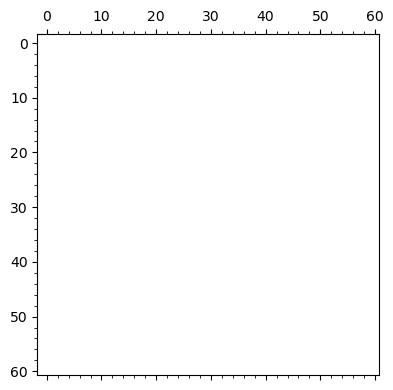

In [66]:
matrix_plot(omega_41)

## Taking invariants at gates.

The weight function $\mathbb{Z}^{60} \to \mathbb{Z}^{24}$ is given by a 24 by 60 matrix `weights_41`. Its right kernel is the invariant sublattice.

### Weight Matrix

In [6]:

# first keep track of the ordering on the vertices. Need this to make a basis.
vertex_index_list = [[k,i,j] for k in ['a','b'] for i in range(4) for j in range(4) if i != j]
vertex_dict = {'V{0}{1}{2}'.format(*vertex_index_list[i]) : std_basis(i,len(vertex_index_list)) for i in range(len(vertex_index_list)) }
#print(vertex_dict)

# order on rows is a11, a12,...,a43,A1,...,A6,b11,...,B6,x1,x2,...,y's,z's,w's
weights_41 = matrix(ZZ,[
    vertex_dict['Va21']-vertex_dict['Va31'], # a11 - al21
    vertex_dict['Va31']-vertex_dict['Va01'], # a12 - al31
    vertex_dict['Va01']-vertex_dict['Va21'], # a13 - al01
    vertex_dict['Va02']-vertex_dict['Va32'], # a21 - al02
    vertex_dict['Va32']-vertex_dict['Va12'], # a22 - al32
    vertex_dict['Va12']-vertex_dict['Va02'], # a23 - al12
    vertex_dict['Va30']-vertex_dict['Va20'], # a31 - al30
    vertex_dict['Va20']-vertex_dict['Va10'], # a32 - al20
    vertex_dict['Va10']-vertex_dict['Va30'], # a33 - al10
    vertex_dict['Va13']-vertex_dict['Va23'], # a41 - al13
    vertex_dict['Va23']-vertex_dict['Va03'], # a42 - al23
    vertex_dict['Va03']-vertex_dict['Va13'], # a43 - al03
    vertex_dict['Va10']+vertex_dict['Va23'], # A1 - A03
    vertex_dict['Va30']+vertex_dict['Va12'], # A2 - A02
    vertex_dict['Va32']+vertex_dict['Va01'], # A3 - A12
    vertex_dict['Va21']+vertex_dict['Va03'], # A4 - A13
    vertex_dict['Va20']+vertex_dict['Va31'], # A5 - A01
    vertex_dict['Va13']+vertex_dict['Va02'], # A6 - A23
    vertex_dict['Vb21']-vertex_dict['Vb31'], # b11 - be21
    vertex_dict['Vb31']-vertex_dict['Vb01'], # b12 - be31
    vertex_dict['Vb01']-vertex_dict['Vb21'], # b13 - be01
    vertex_dict['Vb02']-vertex_dict['Vb32'], # b21 - be02
    vertex_dict['Vb32']-vertex_dict['Vb12'], # b22 - be32
    vertex_dict['Vb12']-vertex_dict['Vb02'], # b23 - be12
    vertex_dict['Vb30']-vertex_dict['Vb20'], # b31 - be30
    vertex_dict['Vb20']-vertex_dict['Vb10'], # b32 - be20
    vertex_dict['Vb10']-vertex_dict['Vb30'], # b33 - be10
    vertex_dict['Vb13']-vertex_dict['Vb23'], # b41 - be13
    vertex_dict['Vb23']-vertex_dict['Vb03'], # b42 - be23
    vertex_dict['Vb03']-vertex_dict['Vb13'], # b43 - be03
    vertex_dict['Vb10']+vertex_dict['Vb23'], # B1 - B03
    vertex_dict['Vb30']+vertex_dict['Vb12'], # B2 - B02
    vertex_dict['Vb32']+vertex_dict['Vb01'], # B3 - B12
    vertex_dict['Vb21']+vertex_dict['Vb03'], # B4 - B13
    vertex_dict['Vb20']+vertex_dict['Vb31'], # B5 - B01
    vertex_dict['Vb13']+vertex_dict['Vb02'], # B6 - B23
    # x1,...,x6
    vertex_dict['Vb32']-vertex_dict['Va03'],
    vertex_dict['Va13']-vertex_dict['Vb02'],
    vertex_dict['Vb13']-vertex_dict['Va02'],
    vertex_dict['Va32']-vertex_dict['Vb03'],
    vertex_dict['Vb21']-vertex_dict['Va01'],
    vertex_dict['Va21']-vertex_dict['Vb01'],
    # y1,...,y6
    vertex_dict['Va23']-vertex_dict['Vb32'],
    vertex_dict['Vb12']-vertex_dict['Va13'],
    vertex_dict['Va02']-vertex_dict['Vb30'],
    vertex_dict['Vb20']-vertex_dict['Va12'],
    vertex_dict['Va30']-vertex_dict['Vb31'],
    vertex_dict['Vb01']-vertex_dict['Va10'],
    # z1,...,z6
    vertex_dict['Vb03']-vertex_dict['Va23'],
    vertex_dict['Va03']-vertex_dict['Vb23'],
    vertex_dict['Vb10']-vertex_dict['Va21'],
    vertex_dict['Va31']-vertex_dict['Vb20'],
    vertex_dict['Vb31']-vertex_dict['Va20'],
    vertex_dict['Va10']-vertex_dict['Vb21'],
    # w1,...,w6
    vertex_dict['Va12']-vertex_dict['Vb13'],
    vertex_dict['Vb23']-vertex_dict['Va32'],
    vertex_dict['Va01']-vertex_dict['Vb10'],
    vertex_dict['Vb30']-vertex_dict['Va31'],
    vertex_dict['Va20']-vertex_dict['Vb12'],
    vertex_dict['Vb02']-vertex_dict['Va30']
]).transpose()


In [7]:
# The right kernel is the sublattice of invariants with respect to the T-action at all 24 gates.
invariant_sublattice_41 = weights_41.right_kernel()
print("Rank of invariant sublattice:", invariant_sublattice_41.rank())

for v in invariant_sublattice_41.basis():
    #print out the kernel elements
    print(matrix(Rnew,v)*new_coeffs.transpose())

Rank of invariant sublattice: 36
[al21 - be10 + z3 - w4]
[al31 + be10 + w3 + w4]
[al01 - z3 - w3]
[al02 + be03 + x4 - y3 - y4 - z4 - w1 - w4]
[al32 - be03 - x4 + w1]
[al12 + y3 + y4 + z4 + w4]
[al30 - y5 - z5]
[al20 - be03 + B13 - B23 + y5 + z5 + z6 + w6]
[al10 + be03 - B13 + B23 - z6 - w6]
[al13 - be10 + B13 - B23 + x6 + y2 - y4 + y5 + y6 - z1 + z3 - z4 + z5 + z6 - w1 - w4 + w5 + w6]
[al23 + x4 + z1 + z2 + w2]
[al03 + be10 - B13 + B23 - x4 - x6 - y2 + y4 - y5 - y6 - z2 - z3 + z4 - z5 - z6 + w1 - w2 + w4 - w5 - w6]
[A03 - B13 + z1 - z6]
[A02 - B23 - w1 + w6]
[A12 - B13 - x4 - x6 - y6 - z3 - z6 - w3]
[A13 - B13 - x4 - x6 - y6 - z2 - z6 - w2]
[A01 - B23 - y4 + y5 - z4 + z5 - w1 + w6]
[A23 - B23 + y2 - y3 - y4 + y5 - z4 + z5 - w1 - w4 + w5 + w6]
[be21 + be03 - B13 + B23 - y5 - w6]
[be31 - be03 + B13 - B23 + y5 + y6 + z6 + w6]
[be01 - y6 - z6]
[be02 - be10 + B13 - B23 + x6 - y1 - y4 + y6 - z1 + z3 - z4 + z6 - w1 - w4]
[be32 + be10 - B13 + B23 - x6 + y1 + y4 - y5 - y6 + z1 - z3 + z4 - z5 - 

In [54]:
invariant_sublattice_41

Free module of degree 60 and rank 36 over Integer Ring
Echelon basis matrix:
[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0 -1  0  0]
[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0]
[ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  0  0  0]
[ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0 -1 -1  0  0  0  0  0 -1  0  0 -1  0  0 -1  0  0]
[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
[ 0  0  0  0 

## Quotients

Any quotient of the form $M^{x} = 1$ in the quantum torus can be expressed in terms of the lattice as $x = 0$. We want to quotient by
1. Monodromy at each of the 8 punctures
1. The gluing constraints, 6 from each face so 24 total.
1. Monodromy around the long edge handles - looks like there are 2 from each edge so 4 total.
1. The great circle relations, 1 from each tetrahedron so 2 total.

The first three types of relations are monomial. I expect to get a lattice of rank 3 once those are imposed. The last relation will have to be done in terms of the quantum torus, not the lattice.


### Monodromy and Gluing Quotients

In [8]:
%run quantum_tori.ipynb

In [9]:
list_of_gluing_constraints_41 = [ # first short edges. The loop is x2 a11 x1 b43 and set equal to 1
    # the order depends on the orientation around the loop.
    dict_monomial_to_list(constraint) for constraint in [
        multiply_lattice_monomials(
            new_gens(thread1),new_gens(edgeA),new_gens(thread2),new_gens(edgeB),
            relations=omega_41
        )
        for thread1,edgeA,thread2,edgeB in [
            ('x2','al03','x1','be02'),
            ('x4','al02','x3','be03'),
            ('x6','al01','x5','be01'),
            ('y1','al13','y2','be32'),
            ('y3','al12','y4','be30'),
            ('y5','al10','y6','be31'),
            ('z2','al23','z1','be23'),
            ('z4','al21','z3','be20'),
            ('z6','al20','z5','be21'),
            ('w1','al32','w2','be13'),
            ('w3','al31','w4','be10'),
            ('w5','al30','w6','be12')
        ]
    ]
] + [ # then long edges. These get set to 1. It's :x2 A4:(:x3 B6:)^{-1} = 1.
    dict_monomial_to_list(constraint) for constraint in [ 
        multiply_polynomials(
            { tuple( new_gens(thread1)+new_gens(edgeA)):1 },
            { tuple(-new_gens(thread2)-new_gens(edgeB)):1 },
            relations=omega_41
        )
        for thread1,edgeA,thread2,edgeB in [
            ('x2','B23','x3','A23'),
            ('x4','B13','x5','A12'),
            ('x6','B12','x1','A13'),
            ('y2','A23','y3','B02'),
            ('y4','A02','y5','B01'),
            ('y6','A03','y1','B12'),
            ('z2','B03','z3','A13'),
            ('z4','B01','z5','A01'),
            ('z6','B13','z1','A03'),
            ('w2','A12','w3','B03'),
            ('w4','A01','w5','B02'),
            ('w6','A02','w1','B23')
        ]
    ]
]

# check that these are T^{24}-invariant and central:
print("Checking Gluing Constraints:")
for constraint in list_of_gluing_constraints_41:
    v = weights_41*vector(constraint)
    if not v.is_zero():  print("Not Invariant!:", new_coeffs*matrix(Rnew,constraint).transpose())
#    if not (invariant_sublattice_41.subspace([constraint])).is_subspace(kernel_space_41): print("Not in kernel:", constraint)


# Monodromy: The loop around the puncture is a1p a2p a3p. If it's set to 1, then I need to quotient by ap1 ap2 ap3 = 1
    
list_of_monodromy_constraints_41 = [ dict_monomial_to_list(constraint) for constraint in [ 
    multiply_lattice_monomials(
        new_gens(edge1),new_gens(edge2),new_gens(edge3),relations=omega_41
    )
    for edge1,edge2,edge3 in [
            ('al10','al20','al30'),
            ('al01','al21','al31'),
            ('al02','al12','al32'),
            ('al03','al13','al23'),
            ('be10','be20','be30'),
            ('be01','be21','be31'),
            ('be02','be12','be32'),
            ('be03','be13','be23'),
        ]
    ]
]

# check that these are T^{24}-invariant
print("Checking Monodromy Constraints:")
for constraint in list_of_monodromy_constraints_41:
    v = weights_41*vector(constraint)
    if not v.is_zero():  print("Not Invariant!:", new_coeffs*matrix(Rnew,constraint).transpose())
    # to check if they're central. I don't think they should be.
    #if not (invariant_sublattice_41.subspace([constraint])).is_subspace(kernel_space_41): print("Not in kernel:", constraint)

    list_of_thread_monodromy_constraints_41 = [ # the loop is (threads in ccw order) -> 1
    dict_monomial_to_list(constraint) for constraint in [
        multiply_lattice_monomials(
            *[lat[e] for e in edges],
            relations=omega_41
        )
        for edges in [
            ('x1', 'x4', 'y1', 'z1', 'z2', 'w2'),
            ('x2', 'y2', 'y5', 'z5', 'w5', 'w6'),
            ('x3', 'y3', 'y4', 'z4', 'w1', 'w4'),
            ('x5', 'x6', 'y6', 'z3', 'z6', 'w3')
        ]
    ]
]

# check that these are T^{24}-invariant 
print("Checking Thread Monodromy Constraints:")
for constraint in list_of_thread_monodromy_constraints_41:
    v = weights_41*vector(constraint)
    if not v.is_zero():  print("Not Invariant!:", constraint)
        
        
# Take the quotient!
#quotient_41 = invariant_sublattice_41.quotient(list_of_monodromy_constraints_41+list_of_gluing_constraints_41)

#print("Ambient space dimensions:",invariant_sublattice_41.dimension())
#print("Constraint space dimensions:",invariant_sublattice_41.subspace(list_of_monodromy_constraints_41+list_of_gluing_constraints_41).dimension())
#print("Quotient ngens:",quotient_41.ngens())

Checking Gluing Constraints:
Checking Monodromy Constraints:
Checking Thread Monodromy Constraints:


### Full Quotient!
We expect this to have three generators.

In [10]:
full_quotient_41 = invariant_sublattice_41.quotient(
    list_of_gluing_constraints_41
    + list_of_monodromy_constraints_41
    + list_of_thread_monodromy_constraints_41
)

print("Full (threads+monodromy+gluing) quotient ngens: ", full_quotient_41.ngens())
pi = full_quotient_41.coerce_map_from(full_quotient_41.V())
for gen in full_quotient_41.gens():
    print(new_coeffs*vector(Rnew,list(gen.lift())))

Full (threads+monodromy+gluing) quotient ngens:  3
(al21 - be10 + z3 - w4)
(al20 - be03 + B13 - B23 + y5 + z5 + z6 + w6)
(al13 - be10 + B13 - B23 + x6 + y2 - y4 + y5 + y6 - z1 + z3 - z4 + z5 + z6 - w1 - w4 + w5 + w6)


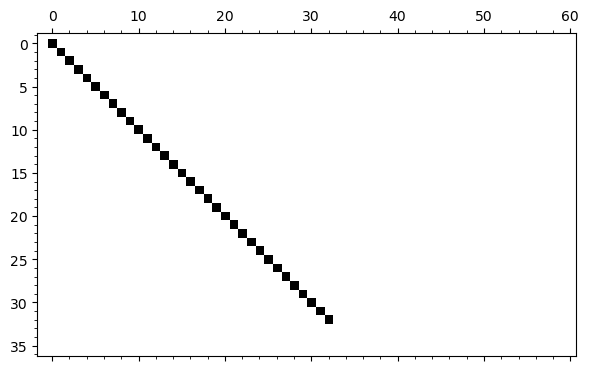

In [19]:
# Get the smith normal form - if this has values other than 1 along the diagonal then there's torsion
relations_matrix = Matrix(ZZ,list_of_gluing_constraints_41
    + list_of_monodromy_constraints_41
    + list_of_thread_monodromy_constraints_41)
matrix_plot(relations_matrix.smith_form()[0])

In [48]:
# lets print all the constraints
# All of the T-region monodromy constraints should be set to qdim(1). 
print("thread monodromy.")
for constraint in list_of_thread_monodromy_constraints_41:
    print(new_coeffs*vector(Rnew,constraint))
    
print("monodromy.")
for constraint in list_of_monodromy_constraints_41:
    print(new_coeffs*vector(Rnew,constraint))
    
print("gluing.")
for constraint in list_of_gluing_constraints_41:
    print(new_coeffs*vector(Rnew,constraint))

thread monodromy.
(x1 + x4 + y1 + z1 + z2 + w2)
(x2 + y2 + y5 + z5 + w5 + w6)
(x3 + y3 + y4 + z4 + w1 + w4)
(x5 + x6 + y6 + z3 + z6 + w3)
monodromy.
(al30 + al20 + al10)
(al21 + al31 + al01)
(al02 + al32 + al12)
(al13 + al23 + al03)
(be30 + be20 + be10)
(be21 + be31 + be01)
(be02 + be32 + be12)
(be13 + be23 + be03)
gluing.
(al03 + be02 + x1 + x2)
(al02 + be03 + x3 + x4)
(al01 + be01 + x5 + x6)
(al13 + be32 + y1 + y2)
(al12 + be30 + y3 + y4)
(al10 + be31 + y5 + y6)
(al23 + be23 + z1 + z2)
(al21 + be20 + z3 + z4)
(al20 + be21 + z5 + z6)
(al32 + be13 + w1 + w2)
(al31 + be10 + w3 + w4)
(al30 + be12 + w5 + w6)
(-A23 + B23 + x2 - x3)
(-A12 + B13 + x4 - x5)
(-A13 + B12 - x1 + x6)
(A23 - B02 + y2 - y3)
(A02 - B01 + y4 - y5)
(A03 - B12 - y1 + y6)
(-A13 + B03 + z2 - z3)
(-A01 + B01 + z4 - z5)
(-A03 + B13 - z1 + z6)
(A12 - B03 + w2 - w3)
(A01 - B02 + w4 - w5)
(A02 - B23 - w1 + w6)


### The great circles

These are *not* monomials, so I can't take the quotient using the lattice. Here I translate each term into the lattice though, to see if they'll simplify.

In [197]:
%run quantum_tori.ipynb

In [12]:
def list_to_module_element(the_list,the_module):
    """
    Turns a list into a module element.
    Plays the role that the_module.monomial() would if it were implemented.
    
    Parameters:
    the_list (List) - the lattice coordinate of a module element.
    the_module (fgp_module) - the ambient module
    
    Returns:
    (the_module.element_class) - the module element you'd *expect* from typing the_module(the_list)
    """
    return the_module.sum([
        term[0]*term[1] for term in zip(the_list,the_module.gens())
    ])

In [15]:
### Generators for the glued surface!

extra_gen = list_to_module_element([0,-1,0],full_quotient_41).lift()
if not (weights_41*vector(extra_gen)).is_zero():
    print("weight of extra generator:",weights_41*extra_gen)
    
print("image in quotient:",pi(extra_gen))

# this is m^2 - I think that's important for comparing to the A-polynomial
m_gen = vector(dict_monomial_to_list(
    multiply_lattice_monomials(
        *[new_gens(edge) for edge in ['x1','al03','al13','y1']],
        relations=omega_41
    )))

if not (weights_41*vector(m_gen)).is_zero():
    print("weight of m:",weights_41*m_gen)
print("image in quotient:",pi(m_gen))

l_gen = dict_monomial_to_list(
    multiply_lattice_monomials(
        *[new_gens(edge) for edge in ['z2','al23','al13','y2','w5','z5','be21','be01','x6','z3','be20','be30','y3','x3','be03','be23']],
        relations=omega_41
    ))
if not (weights_41*vector(l_gen)).is_zero():
    print("weight of l:",weights_41*vector(l_gen))
print("image in quotient:",pi(l_gen))


favorite_basis_matrix = matrix([
    pi(m_gen),
    pi(l_gen),
    pi(extra_gen)
]).transpose()

if favorite_basis_matrix.rank() < favorite_basis_matrix.dimensions()[0]:
    print("WARNING: favorite_basis_matrix is not full rank!")

#print("Commutation Relations in the quotient") # this is assuming that the quotient preserves the commutation relations.
omega_quotient = matrix([m_gen,l_gen,extra_gen])*omega_41*matrix([m_gen,l_gen,extra_gen]).transpose()
#print(omega_quotient)



image in quotient: (0, -1, 0)
image in quotient: (1, 0, 0)
image in quotient: (1, -1, 1)


In [16]:
full_quotient_41

Finitely generated module V/W over Integer Ring with invariants (0, 0, 0)

In [17]:
scafolding_edges_A = -1*(new_gens('A03')+new_gens('A02')+new_gens('A12')+new_gens('A13'))
scafolding_edges_B = -1*(new_gens('B03')+new_gens('B02')+new_gens('B12')+new_gens('B13'))

# Define the great circles as dictionaries. These should be set to 2?

temp_list_A = [
    multiply_lattice_monomials(
        *[scafolding_edges_A,*edges],
        relations=omega_41
    ) for edges in [
                 # 0010
                 [lat['A1'],-lat['a33'],lat['A1'],-lat['a42'],-lat['a22'],lat['A3'],lat['A3'],-lat['a13']],
                 # 0110
                 [lat['a23'],lat['A6'],-lat['a41'],lat['A1'],-lat['a42'],lat['a31'],lat['A5'],-lat['a12'],lat['A3'],-lat['a13']],
                 #0011
                 [lat['A1'],-lat['a33'],  lat['a11'],lat['A5'],-lat['a32'],  -lat['a22'],lat['A3'],  lat['a43'],lat['A6'],-lat['a21']],
                 # 0111
                 [lat['a23'],lat['A6'],-lat['a41'],  lat['a11'],lat['A5'],-lat['a32'], lat['a31'],lat['A5'],-lat['a12'],  lat['a43'],lat['A6'],-lat['a21']],
                 # 1101
                 [lat['a13'],lat['A4'],  lat['a42'],lat['A4'],  lat['a22'],lat['A2'],  lat['a33'],lat['A2']],
                 # 0101
                 [lat['a13'],lat['A4'],  lat['a11'],lat['A5'],-lat['a32'],  lat['a22'],lat['A2'],  lat['a23'],lat['A6'],-lat['a41']],
                 # 1111
                 [lat['a43'],lat['A6'],-lat['a21'],  lat['a42'],lat['A4'],  lat['a31'],lat['A5'],-lat['a12'],  lat['a33'],lat['A2']]
    ] ]



great_circle_A = add_polynomials(*temp_list_A)
print("Great Circle:")
pretty_print(dict_to_free_algebra_element(great_circle_A, lex_order=lex_order_41,free_algebra=R))
    
#print("Great Circle A in the quotient:") # this should be set equal to 2?
great_circle_quot_A = add_polynomials(
    *[{tuple(favorite_basis_matrix*pismall(k)) : v} for k,v in great_circle_A.items()]
)
#print(great_circle_quot_A)

great_circle_B = {}

temp_list_B = [
    multiply_lattice_monomials(
        *[scafolding_edges_B,*edges],
        relations=omega_41
    ) for edges in [
                 # 0010
                 [lat['B1'],-lat['b33'],lat['B1'],-lat['b42'],-lat['b22'],lat['B3'],lat['B3'],-lat['b13']],
                 # 0110
                 [lat['b23'],lat['B6'],-lat['b41'],lat['B1'],-lat['b42'],lat['b31'],lat['B5'],-lat['b12'],lat['B3'],-lat['b13']],
                 #0011
                 [lat['B1'],-lat['b33'],  lat['b11'],lat['B5'],-lat['b32'],  -lat['b22'],lat['B3'], lat['b43'],lat['B6'],-lat['b21']],
                 # 0111
                 [lat['b23'],lat['B6'],-lat['b41'],  lat['b11'],lat['B5'],-lat['b32'], lat['b31'],lat['B5'],-lat['b12'],  lat['b43'],lat['B6'],-lat['b21']],
                 # 1101
                 [lat['b13'],lat['B4'],  lat['b42'],lat['B4'],  lat['b22'],lat['B2'],  lat['b33'],lat['B2']],
                 # 0101
                 [lat['b13'],lat['B4'],  lat['b11'],lat['B5'],-lat['b32'],  lat['b22'],lat['B2'],  lat['b23'],lat['B6'],-lat['b41']],
                 # 1111
                 [lat['b43'],lat['B6'],-lat['b21'],  lat['b42'],lat['B4'],  lat['b31'],lat['B5'],-lat['b12'],  lat['b33'],lat['B2']]
    ] ]

great_circle_B = add_polynomials(*temp_list_B)

#print("Great Circle B in the quotient:") # this should be set equal to 2?
great_circle_quot_B = add_polynomials(
    *[{tuple(favorite_basis_matrix*pismall(k)):v} for k,v in great_circle_B.items()]
)
#print(great_circle_quot_B)


Great Circle:
1*a13^-1*a22^-1*a33^-1*a42^-1*A1*A2^-1*A3*A4^-1 + 1*a12^-1*a13^-1*a23*a31*a41^-1*a42^-1*A2^-1*A4^-1*A5*A6 + 1*a11*a21^-1*a22^-1*a32^-1*a33^-1*a43*A2^-1*A4^-1*A5*A6 + 1*a11*a12^-1*a21^-1*a23*a31*a32^-1*a41^-1*a43*A1^-1*A2^-1*A3^-1*A4^-1*A5^2*A6^2 + 1*a13*a22*a33*a42*A1^-1*A2*A3^-1*A4 + 1*a11*a13*a22*a23*a32^-1*a41^-1*A1^-1*A3^-1*A5*A6 + 1*a12^-1*a21^-1*a31*a33*a42*a43*A1^-1*A3^-1*A5*A6


a13*a22*a33*a42*A1^-1*A2*A3^-1*A4 + a11*a13*a22*a23*a32^-1*a41^-1*A1^-1*A3^-1*A5*A6 + a12^-1*a21^-1*a31*a33*a42*a43*A1^-1*A3^-1*A5*A6 + a11*a12^-1*a21^-1*a23*a31*a32^-1*a41^-1*a43*A1^-1*A2^-1*A3^-1*A4^-1*A5^2*A6^2 + a12^-1*a13^-1*a23*a31*a41^-1*a42^-1*A2^-1*A4^-1*A5*A6 + a11*a21^-1*a22^-1*a32^-1*a33^-1*a43*A2^-1*A4^-1*A5*A6 + a13^-1*a22^-1*a33^-1*a42^-1*A1*A2^-1*A3*A4^-1

NameError: name 'pismall' is not defined

In [36]:
# Making the quotient algebras. These should be the classical (q=1) skein algebra of the surface.
#quotient_free_algebra = FreeAlgebra(QQ,['g','l','m'])
quotient_poly_algebra = LaurentPolynomialRing(QQ,['m','l','g'])
# quotient_lex_order = ['m','l','g']

In [37]:
# get the images of the two great circle relations in the quotient:
relation_A = quotient_poly_algebra.sum([
    quotient_poly_algebra(v)*quotient_poly_algebra.monomial(*k) for k,v in great_circle_quot_A.items()
]+[-2])

relation_B = quotient_poly_algebra.sum([
    quotient_poly_algebra(v)*quotient_poly_algebra.monomial(*k) for k,v in great_circle_quot_B.items()
]+[-2])

# then quotient by these:
relations_ideal = quotient_poly_algebra.ideal([relation_A,relation_B])
skein_module_41 = quotient_poly_algebra.quotient_ring(relations_ideal)
A_41 = quotient_poly_algebra('(l^2*m^4-l*(-m^8+m^6+2*m^4+m^2-1)-m^4)') # from CCGLS 1994
print("The A-polynomial in the ideal:")
pretty_print(relations_ideal.reduce(A_41))
print("Is it included:",A_41 in relations_ideal)
# Should l = 1 in the skein module? Longitude bounding a torus.

print("\n The relations:")
pretty_print(relation_A)
pretty_print(relation_B)

The A-polynomial in the ideal:


m^8*l - m^6*l + m^4*l^2 - 2*m^4*l - m^4 - m^2*l + l

Is it included: False

 The relations:


m*l^-1*g - 2 + m^-1*l*g^-1 + 2*l^-1 + 2*m^-1*g^-1 + m^-1*l^-1*g^-1

m^4*l*g^-2 + 2*m^3*g^-1 + 2*m*l*g^-1 + m^2*l^-1 - 2 + m^-2*l

In [40]:
quotient_poly_algebra('(l^2*m^2+l*(-m^4+m^3+2*m^2+m-1)-m^2)') in relations_ideal

False

In [43]:
relation_B*'g^2'

TypeError: can't multiply sequence by non-int of type 'sage.rings.polynomial.laurent_polynomial.LaurentPolynomial_mpair'